In [492]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [493]:
data = pd.read_csv("laptop_price.csv", encoding="ISO-8859-1")

In [494]:
data.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


# DATA PREPROCESSING

In [495]:
data = data.rename(columns = str.lower)

### Checking Null values in the Dataset

In [496]:
data.isnull().sum()

laptop_id           0
company             0
product             0
typename            0
inches              0
screenresolution    0
cpu                 0
ram                 0
memory              0
gpu                 0
opsys               0
weight              0
price_euros         0
dtype: int64

### Droping the laptop ID column

In [497]:
data = data.drop("laptop_id", axis = 1)
data = data.rename(columns={'price_euros':'price'})

### In the screen resolution column, there are multiple useful informations which can't be read properly yet. So we will separate this 3 informations (Screen type, Resolution, Touchscreen) in 3 different columns using regular expression.

In [498]:
data['resolution'] = data['screenresolution'].str.extract(r'(\d+x\d+)')
data['screentype'] = data['screenresolution'].replace(r'(\d+x\d+)','',regex=True)
data['screentype'] = data['screentype'].replace(r'(Full HD|Quad HD|Quad HD|\+|/|4K Ultra HD)','',regex=True)
data['touchscreen'] = data['screentype'].str.extract(r'(Touchscreen)')
data['screentype'] = data['screentype'].replace(r'(Touchscreen)','',regex=True)

In [499]:
data.head()

,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPS Panel Retina Display,NaN
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,,NaN
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPS Panel Retina Display,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPS Panel Retina Display,NaN


### Count the values of newly created columns

In [500]:
data.isnull().sum()

company                0
product                0
typename               0
inches                 0
screenresolution       0
cpu                    0
ram                    0
memory                 0
gpu                    0
opsys                  0
weight                 0
price                  0
resolution             0
screentype             0
touchscreen         1111
dtype: int64

In [501]:
data['touchscreen'] = data['screentype'].str.extract(r'(Touchscreen)')
data['screentype'] = data['screentype'].replace(r'(Touchscreen)','',regex=True)
data['touchscreen'] = data['touchscreen'].replace('Touchscreen',1)
data['touchscreen'] = data['touchscreen'].replace(np.nan,0)
data['screentype']=data['screentype'].replace(r' ','',regex=True)
data['screentype'] = data['screentype'].replace(r'^\s*$', np.nan, regex=True)
data = data.drop('screenresolution', axis=1)

In [502]:
data.head()

,company,product,typename,inches,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0


### We are separating CPU info with CPU frequency using regex again.

In [503]:
data['cpu_freq'] = data['cpu'].str.extract(r'(\d+(?:\.\d+)?GHz)') 
data['cpu_freq'] = data['cpu_freq'].str.replace('GHz', '')
data.rename(columns={'cpu_freq': 'cpu_freq(GHz)'}, inplace=True)
data['cpu_freq(GHz)'] = data['cpu_freq(GHz)'].astype(float)
data['cpu']= data['cpu'].str.replace(r'(\d+(?:\.\d+)?GHz)', '', regex=True)

In [504]:
data.head()

,company,product,typename,inches,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz)
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0,2.3
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0,1.8
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0,2.5
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0,2.7
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0,3.1


### We removed "GB" from each row in RAM column and added it into the column name and turned the column into Integer. This way we can perform numeric calculations on the row.



In [505]:
data['ram'] = data['ram'].str.replace('GB', '')
data.rename(columns={'ram': 'ram(GB)'}, inplace=True)
data['ram(GB)'] = data['ram(GB)'].astype(int)

### We can see that some laptops have 2 hard drives, there are 4 differnt types of disks: 'SSD', ''HDD', 'Hybrid' and 'Flash Storage'. We will create new columns to include all these information.

In [506]:
data['memory_1']=data['memory']
data['memory_1']=data['memory_1'].str.replace('1.0TB','1TB', regex=True)
data['memory_1']=data['memory_1'].str.replace('1TB','1000GB')
data['memory_1']=data['memory_1'].str.replace('2TB','2000GB')
data['memory_1']=data['memory_1'].str.replace('GB','')
data['memory2']=data['memory_1'].str.replace(r' ','')

In [507]:
memory_1=[]
memory_2=[]
for i in data['memory2']:
    if len(re.findall(r'\+',i))==1: # DOUBLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append(one[1])
    else: # SINGLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append('NaN')

### Now we have separated the drives into two lists. We will now create two more lists that will contain the memory types.



In [508]:
memory_1_gb=[]
memory_1_type=[]
for i in memory_1:
    memory_1_type.append(re.findall(r'(\D\w+)',i)[0])
    memory_1_gb.append(re.findall(r'(\d+)',i)[0])

### We created succesfully two lists for memory_1 in order to include the capacity and type for each memory 1

In [509]:
memory_2_gb=[]
memory_2_type=[]
for i in memory_2:
    if i != 'NaN':
        memory_2_type.append(re.findall(r'(\D\w+)',i)[0])
        memory_2_gb.append(re.findall(r'(\d+)',i)[0])
    else:
        memory_2_type.append('NaN')
        memory_2_gb.append(0)

### We created the same two lists that will contain type and capacity also for the second drive and convert to floating type



In [510]:
data['memory_1_sto(GB)'] = memory_1_gb
data['memory_1_type'] = memory_1_type
data['memory_2_sto(GB)'] = memory_2_gb
data['memory_2_type'] = memory_2_type
data['memory_1_sto(GB)'] = data['memory_1_sto(GB)'].astype(float)
data['memory_2_sto(GB)'] = data['memory_2_sto(GB)'].astype(float)

In [511]:
data.head()

,company,product,typename,inches,cpu,ram(GB),memory,gpu,opsys,weight,...,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1,memory2,memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,...,2560x1600,IPSPanelRetinaDisplay,0,2.3,128 SSD,128SSD,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,...,1440x900,NaN,0,1.8,128 Flash Storage,128FlashStorage,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,...,1920x1080,NaN,0,2.5,256 SSD,256SSD,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,...,2880x1800,IPSPanelRetinaDisplay,0,2.7,512 SSD,512SSD,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,...,2560x1600,IPSPanelRetinaDisplay,0,3.1,256 SSD,256SSD,256.0,SSD,0.0,NaN


In [512]:
data=data.drop(['memory_1','memory2','memory'], axis=1)
data = data.replace({'NaN': np.nan})

In [513]:
data.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0,3.1,256.0,SSD,0.0,NaN


### Checking is all rows have a weight specified in kg.


In [514]:
data['weight'].str.contains('kg').sum()

1303

In [515]:
data['weight'] = data['weight'].str.replace('kg','').astype(float)
data.rename(columns={'weight': 'weight(kg)'}, inplace=True)

In [516]:
data.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0,3.1,256.0,SSD,0.0,NaN


In [517]:
data['cpu_brand'] = data['cpu'].str.extract(r'^(\w+)')
data[data['cpu_brand']=='Samsung']

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand
1191,Samsung,Chromebook Plus,2 in 1 Convertible,12.3,Samsung Cortex A72&A53,4,ARM Mali T860 MP4,Chrome OS,1.15,659.0,2400x1600,IPSPanel,0,2.0,32.0,FlashStorage,0.0,NaN,Samsung


### Since this is the only entry containing a Samsung CPU and ARM GPU, we are dropping this row as to simplify the comparison among others.

In [518]:
data=data.drop(1191)

In [519]:
data['gpu_brand'] = data['gpu'].str.extract(r'^(\w+)')

# EXPLORATORY DATA ANALYSIS

### Most Frequent Brand purchased

In [520]:
def visualization(y,title):
    fig, ax  = plt.subplots(figsize=(10,8))  
    ax=sns.countplot(y=y, data=data, palette='magma',order = y.value_counts().index, hue=y)
    
    ax.bar_label(ax.containers[0])
    plt.title(title)
    plt.show

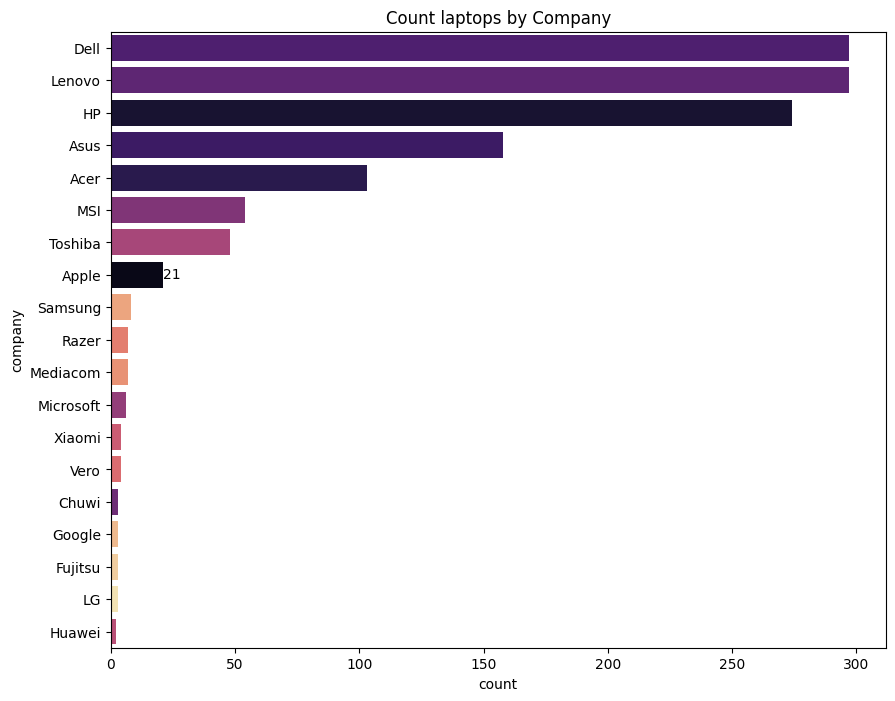

In [521]:
visualization(data.company,"Count laptops by Company")

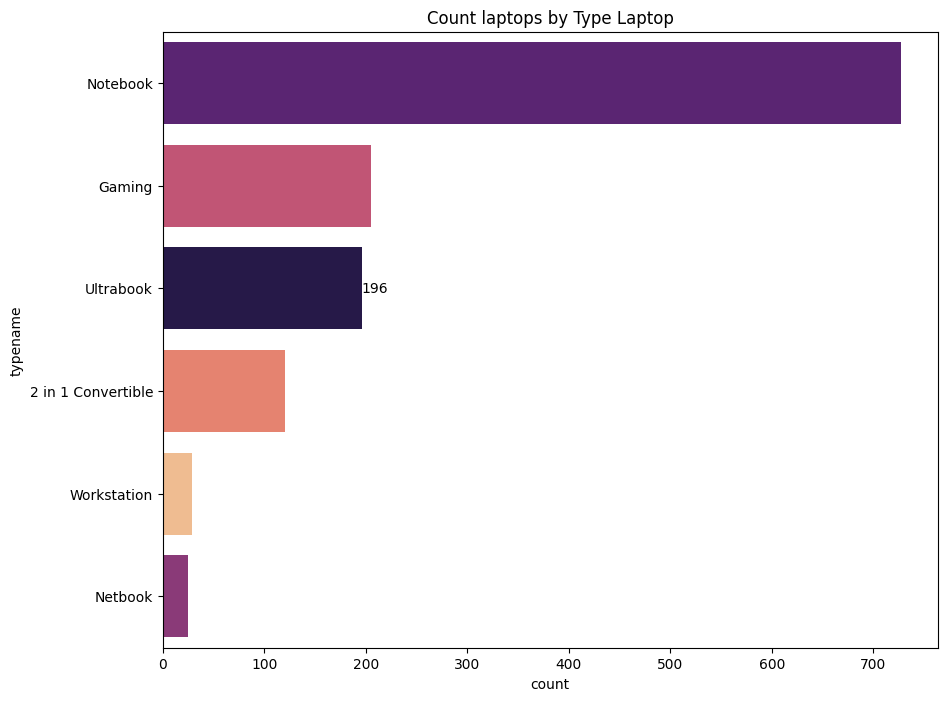

In [522]:
visualization(data.typename,"Count laptops by Type Laptop")

In [523]:
notebook_percentage = '{:.2f}'.format(len(data[data['typename']=='Notebook'])*100/len(data))
print('Most laptops are notebooks, which make ' +notebook_percentage+ '% of the total laptops.')

Most laptops are notebooks, which make 55.84% of the total laptops.


### Most popular screen size¶


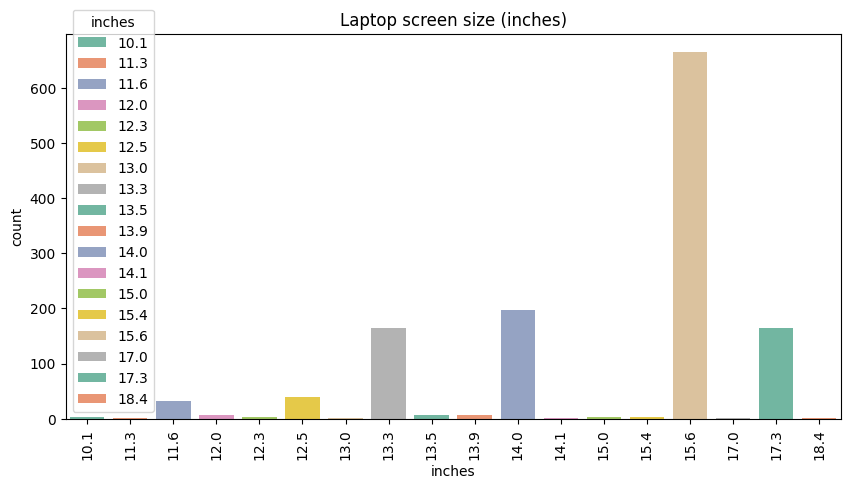

In [524]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='inches', data=data, palette='Set2', hue = 'inches')
ax.set_xticks(range(len(data['inches'].value_counts())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.title('Laptop screen size (inches)')
plt.show()

In [525]:
popular_size_percentage = '{:.2f}'.format(len(data[data['inches']==15.6])*100/len(data))
print('Most laptops have 15.6 inches screen size, which make ' +popular_size_percentage+ '% of the total laptops.')

Most laptops have 15.6 inches screen size, which make 51.08% of the total laptops.


### Since there are a few laptops with non conventional sizes, we will only keep laptops with the conventional sizes.



In [526]:
inches_list = data['inches'].value_counts().index[:6].tolist()
inches_list

[15.6, 14.0, 13.3, 17.3, 12.5, 11.6]

In [527]:
data = data[data['inches'].isin(inches_list)]

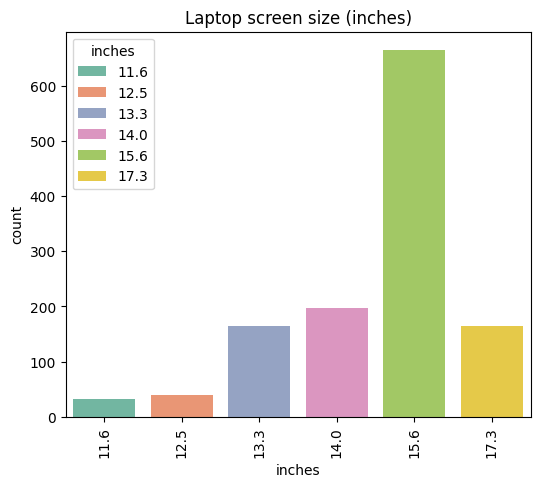

In [528]:
fig, ax  = plt.subplots(figsize=(6,5))
ax=sns.countplot(x='inches', data=data, palette='Set2', hue = 'inches')
ax.set_xticks(range(len(data['inches'].value_counts())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.title('Laptop screen size (inches)')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

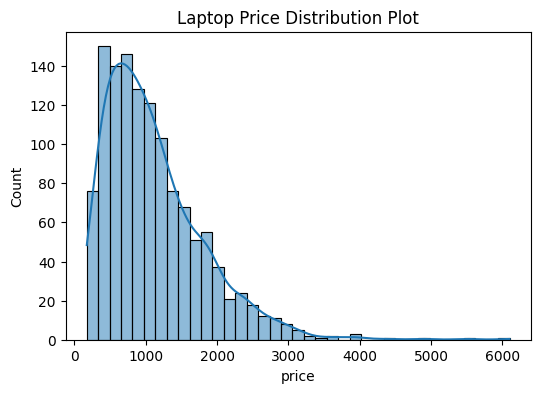

In [529]:
plt.subplots(figsize=(6,4))  
sns.histplot(data['price'], kde = True)
plt.title('Laptop Price Distribution Plot')
plt.show

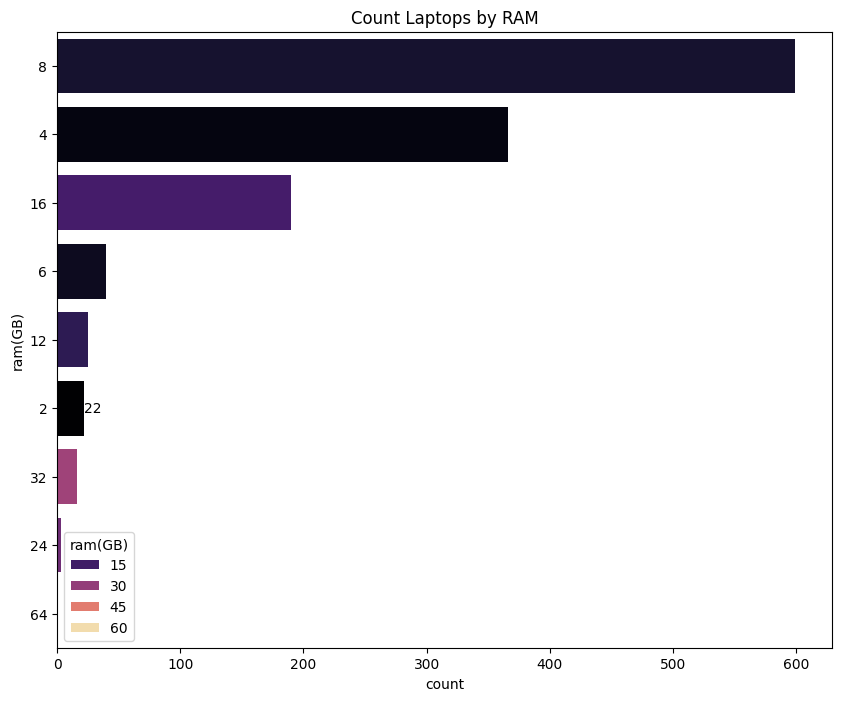

In [530]:
visualization(data['ram(GB)'],"Count Laptops by RAM")

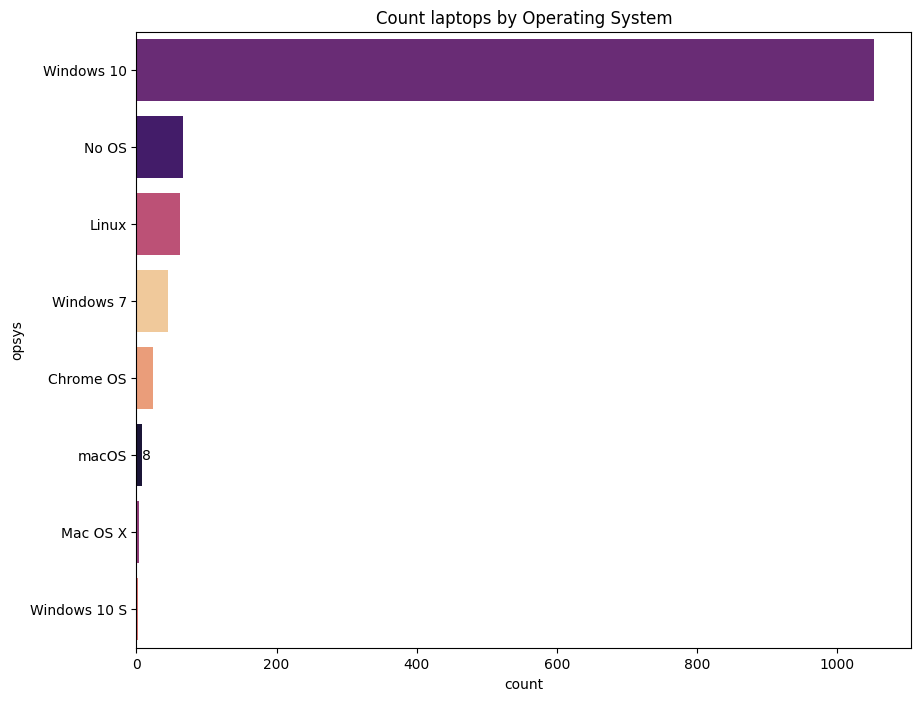

In [531]:
visualization(data['opsys'],"Count laptops by Operating System")

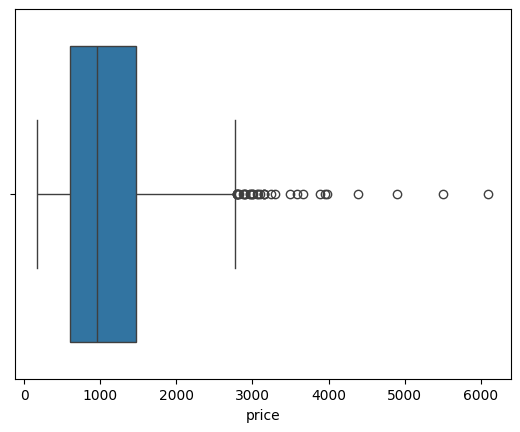

In [532]:
ax=sns.boxplot(x='price', data=data)

C:\Users\KEERTHI RAJ\AppData\Local\Temp\ipykernel_21784\2233695658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=data['price'], x = data['ram(GB)'], palette='magma')


<function matplotlib.pyplot.show(close=None, block=None)>

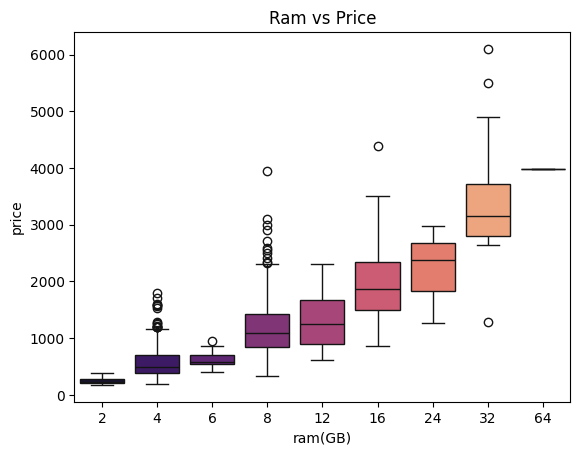

In [533]:
plt.title('Ram vs Price')
sns.boxplot(y=data['price'], x = data['ram(GB)'], palette='magma')
plt.show

C:\Users\KEERTHI RAJ\AppData\Local\Temp\ipykernel_21784\559728696.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['price'], y = data['resolution'], palette='magma')


<function matplotlib.pyplot.show(close=None, block=None)>

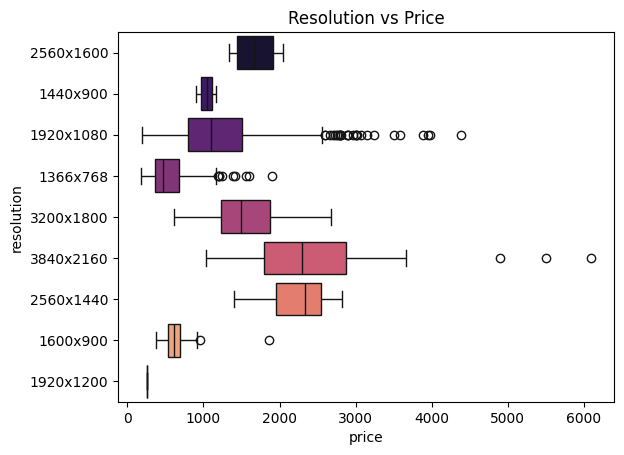

In [534]:
plt.title('Resolution vs Price')
sns.boxplot(x=data['price'], y = data['resolution'], palette='magma')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

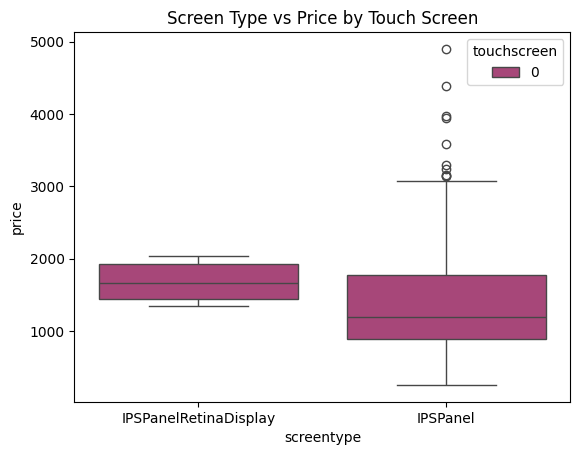

In [535]:
plt.title('Screen Type vs Price by Touch Screen')
sns.boxplot(y=data['price'], x = data['screentype'],hue = data['touchscreen'], palette='magma')
plt.show

# Outliers detection

In [536]:
def lr_plot(data, col_x, col_y, leg):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[col_x],data[col_y])
    sns.regplot(x=col_x, y = col_y, data=data, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend(loc=leg, ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
    plt.title(col_y + ' VS ' + col_x)
    plt.show()

    return slope, intercept

#### Price vs RAM

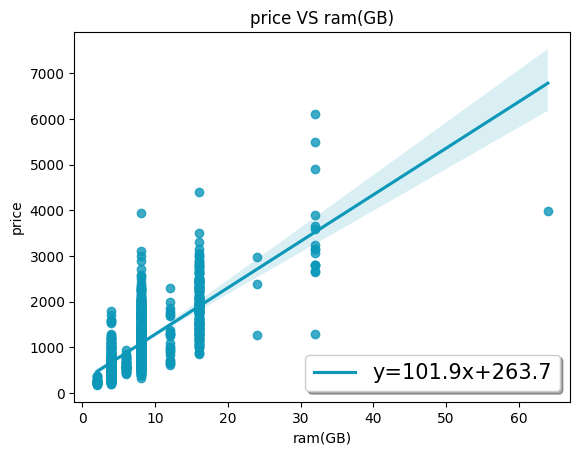

In [537]:
slope, intercept = lr_plot(data,'ram(GB)','price', 'lower right')

In [538]:
data = data[data['ram(GB)']<60]

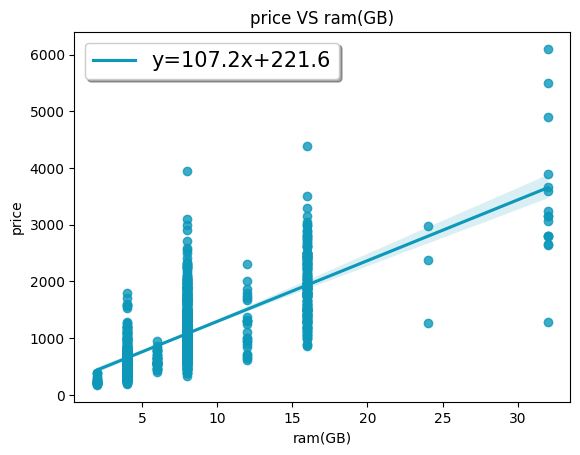

In [539]:
slope, intercept = lr_plot(data,'ram(GB)','price', 'upper left')

### Price vs CPU Frequency

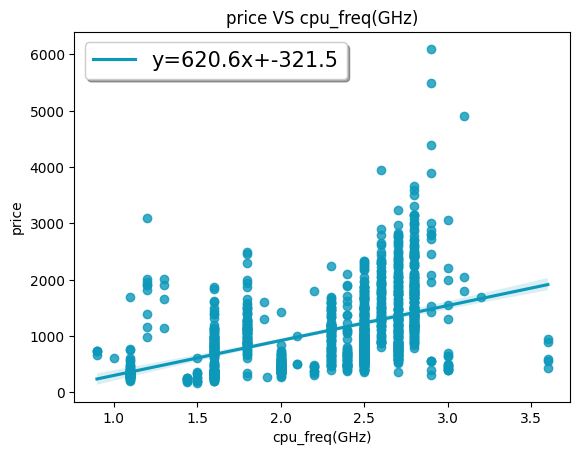

In [540]:
slope, intercept = lr_plot(data,'cpu_freq(GHz)','price', 'upper left')

In [541]:
print("We can see a positive trend between price and the CPU frequency, with no obvious outliers.")

We can see a positive trend between price and the CPU frequency, with no obvious outliers.


### Price vs Inches


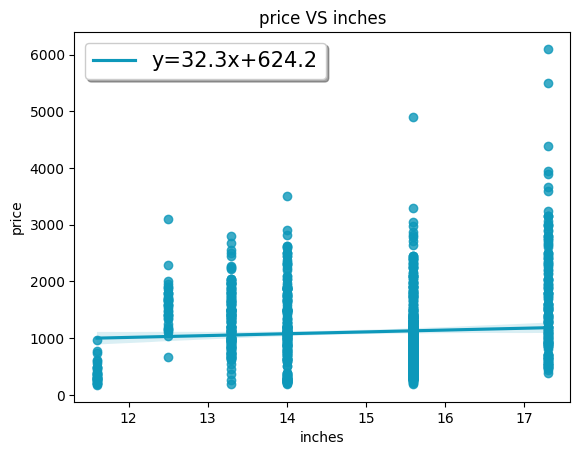

In [542]:
slope, intercept = lr_plot(data,'inches','price', 'upper left')

### Price vs CPU Brand (Grouped by GPU Brand)¶


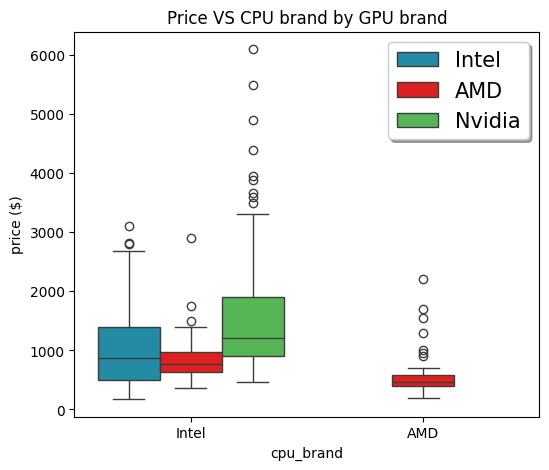

In [543]:
cpu_palette = {'Intel':'#0d98ba', 'AMD':'#FF0000', 'Nvidia':'#46C646'}
fig, ax = plt.subplots(figsize=(6,5))
sns.boxplot(x='cpu_brand', y='price', data=data, hue='gpu_brand', palette=cpu_palette)
ax.set_title('Price vs CPU brand by GPU brand')
plt.ylabel('price ($)')
plt.legend(loc='upper right', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
plt.title('Price VS CPU brand by GPU brand')
plt.show()

#### Laptops with Intel CPUs are more expensive.
#### Laptops with an AMD CPUs also have and AMD GPUs
#### Laptops with Nvidia GPUs are more expensive.

### Most common GPUs

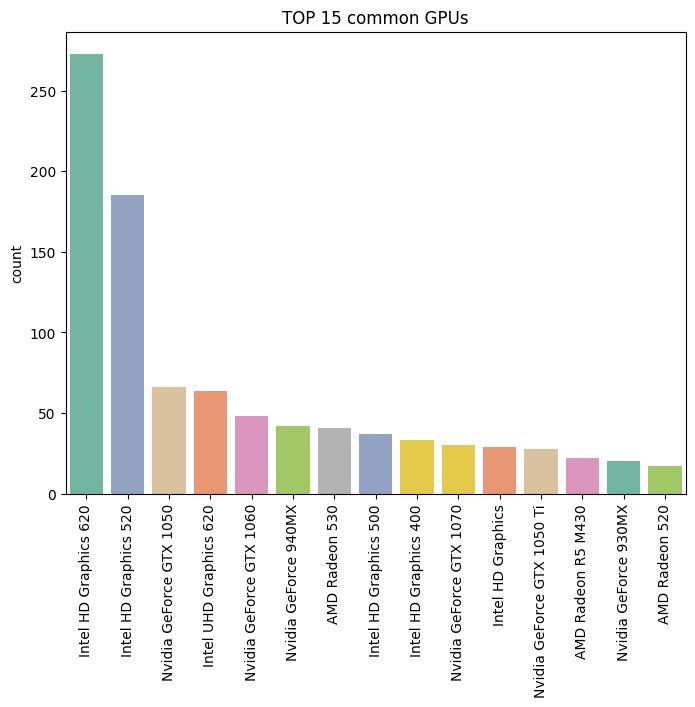

In [544]:
gpulist = data['gpu'].value_counts()[:15].index.tolist()
plt.figure(figsize=(8,6))
ax=sns.countplot(x='gpu', data=data[data['gpu'].isin(gpulist)], order = gpulist, palette='Set2', hue = 'gpu')
plt.xticks(rotation=90);
plt.title('TOP 15 common GPUs')
plt.xlabel('')
plt.show()

#### The 2 most common GPUs are integrated Intel GPUs HD Graphics 620 and 520, while the third one is the Nvidia GTX1050.



### Most common CPUS

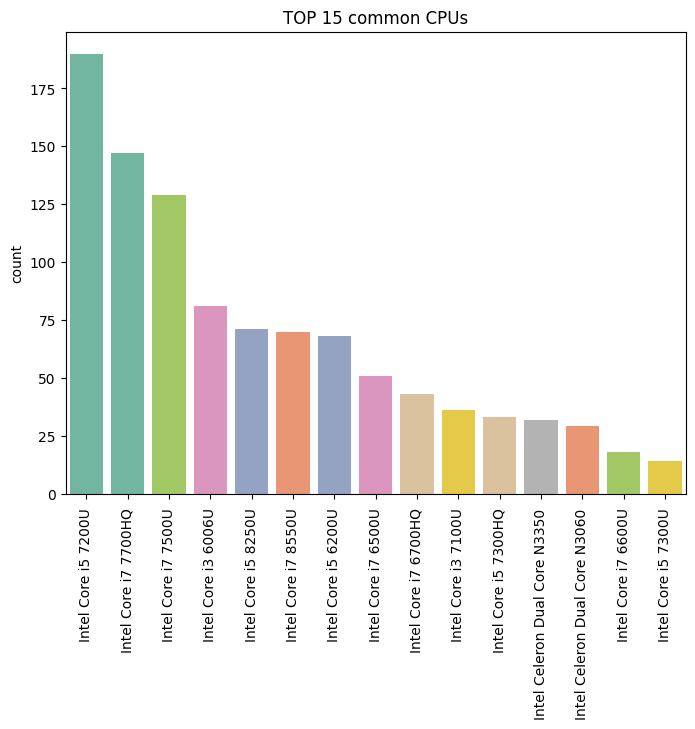

In [545]:
cpulist = data['cpu'].value_counts()[:15].index.tolist()
plt.figure(figsize=(8,6))
ax=sns.countplot(x='cpu', data=data[data['cpu'].isin(cpulist)], order = cpulist, palette='Set2', hue = 'cpu')
plt.xticks(rotation=90)
plt.title('TOP 15 common CPUs')
plt.xlabel('')
plt.show()

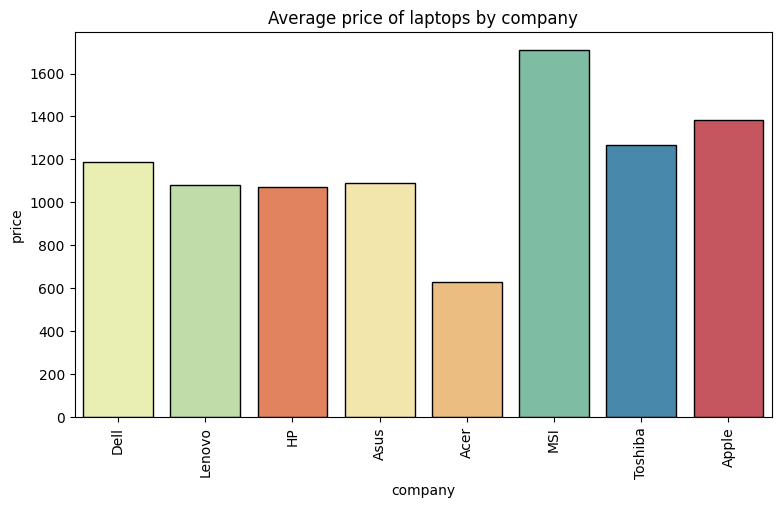

In [546]:
companylist = data['company'].value_counts().index[:8].tolist()
plt.figure(figsize=(9,5))
ax=sns.barplot(x='company', y='price', data=data[data['company'].isin(companylist)], hue = 'company',order=companylist,palette='Spectral',errorbar=('ci', False),edgecolor="black")
plt.xticks(rotation=90)
plt.title('Average price of laptops by company')
plt.show()

#### MSI laptops are on average the most expensive, with an average price of 1708.72$.

#### Acer are the cheapest, with an average price of 626$.

#### Laptops from Dell, Lenovo, HP and Asus have, on average, a price around 1000$.

### Correlation Matrix

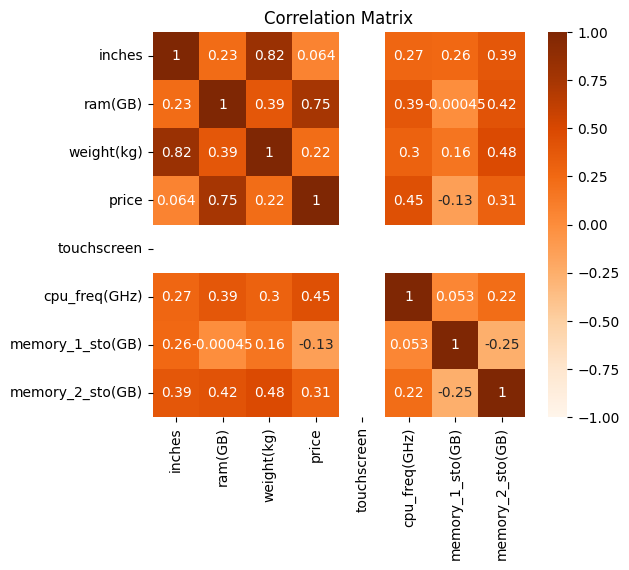

In [547]:
plt.figure(figsize=(6, 5))
sns.heatmap(data.corr(numeric_only=True), cmap='Oranges', annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### RAM has a high positive correlation with price (+0.75): more expensive laptops tends to have a higher price.
#### CPU Freq has a quite moderate positive correlation with the price (+0.45).
#### Inches and Weight have a high positive correlation (+0.82) since laptops with bigger screens tend to be heavier.

In [548]:
catCols =  ['company','product','typename','cpu','gpu','opsys','resolution', 'screentype','resolution','memory_1_type','memory_2_type', 'gpu_brand','cpu_brand']

In [549]:
print('For One Hot Encoding')
print('Dataframe Encoded Dimension: ', pd.get_dummies(data, columns=catCols, drop_first=True).shape)

For One Hot Encoding
Dataframe Encoded Dimension:  (1261, 847)


In [550]:
en = LabelEncoder()
for cols in catCols:
    data[cols] = en.fit_transform(data[cols])
    
print('For Label Encoding')
print('Dataframe Encoded Dimension: ', data.shape)

For Label Encoding
Dataframe Encoded Dimension:  (1261, 20)


In [551]:
data.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,1,295,4,13.3,46,8,52,7,1.37,1339.69,6,1,0,2.3,128.0,3,0.0,3,1,1
1,1,296,4,13.3,46,8,45,7,1.34,898.94,1,2,0,1.8,128.0,0,0.0,3,1,1
2,6,49,3,15.6,52,8,47,3,1.86,575.00,3,2,0,2.5,256.0,3,0.0,3,1,1
4,1,295,4,13.3,46,8,53,7,1.37,1803.60,6,1,0,3.1,256.0,3,0.0,3,1,1
5,0,57,3,15.6,11,4,13,4,2.10,400.00,0,2,0,3.0,500.0,1,0.0,3,0,0


In [552]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1261 entries, 0 to 1302
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1261 non-null   int32  
 1   product           1261 non-null   int32  
 2   typename          1261 non-null   int32  
 3   inches            1261 non-null   float64
 4   cpu               1261 non-null   int32  
 5   ram(GB)           1261 non-null   int32  
 6   gpu               1261 non-null   int32  
 7   opsys             1261 non-null   int32  
 8   weight(kg)        1261 non-null   float64
 9   price             1261 non-null   float64
 10  resolution        1261 non-null   int64  
 11  screentype        1261 non-null   int32  
 12  touchscreen       1261 non-null   int64  
 13  cpu_freq(GHz)     1261 non-null   float64
 14  memory_1_sto(GB)  1261 non-null   float64
 15  memory_1_type     1261 non-null   int32  
 16  memory_2_sto(GB)  1261 non-null   float64
 17  

# MODEL PREDICTION

In [553]:
X = data.drop('price', axis = 1)
y = data['price']

In [554]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [555]:
randomforest = RandomForestRegressor(n_estimators=150, max_depth=None, max_features=20)

In [556]:
randomforest.fit(X_train, y_train)

RandomForestRegressor(max_features=20, n_estimators=150)

In [557]:
y_predict_randomforest = randomforest.predict(X_test)

In [558]:
y_predict_randomforest

array([1512.72133333, 1451.97246667, 1322.22073333,  553.38281587,
       2002.63766667,  696.786     , 1153.89817778,  291.79926667,
       1596.21953333, 1268.34406667, 1056.43613333, 1186.81751111,
        806.34891111,  384.52753333,  931.517     ,  662.23726667,
       1022.0974    , 1109.42926667,  811.73253333, 1740.0576    ,
        997.5444    ,  604.5994    ,  732.06933333, 1107.41366667,
       1373.01766667,  462.9354    ,  256.9776    ,  603.81333333,
       1044.25846667, 1020.84966667, 1307.1628    , 1056.25473333,
       2455.98146667,  999.3262    , 1923.81793333,  647.91      ,
       1287.40526667, 1650.9836    , 1002.22077778, 1821.36946667,
        396.09433333, 1489.17666667,  867.14766667,  330.25006667,
       1530.367     ,  411.53486667, 1479.8604    , 1637.96153333,
       2857.58333333, 1221.58901333,  437.42291111,  645.79437778,
        289.02133333, 1378.47933333,  745.3004    ,  741.25786667,
       2018.82853333, 1418.408     , 1048.71413333,  547.23982

# Model Evaluation & Metrics

In [559]:
mse_randomforest = mean_squared_error(y_test, y_predict_randomforest)
print(f"RMSE using Random Forest {np.round(np.sqrt(mse_randomforest),4)}")

RMSE using Random Forest 266.1298


In [560]:
print(f"R2 using Random Forest: {np.round(r2_score(y_test, y_predict_randomforest),4)*100}")

R2 using Random Forest: 85.38


In [561]:
mse = mean_squared_error(y_test, y_predict_randomforest)
mae = mean_absolute_error(y_test, y_predict_randomforest)
r2 = r2_score(y_test, y_predict_randomforest)

print("Random Forest Regressor")
print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

Random Forest Regressor
Evaluation Metrics:
Mean Squared Error (MSE): 70825.0825
Mean Absolute Error (MAE): 162.5640
R-squared (R2) Score: 0.8538


### INFLUENTIAL FEATURES

In [562]:
randomforest.feature_names = data.drop(['price'], axis = 1).columns
randomforest_features = pd.DataFrame({'feature': randomforest.feature_names ,'importance':randomforest.feature_importances_})

In [563]:
randomforest_sorted_features = randomforest_features.sort_values('importance', ascending = False)

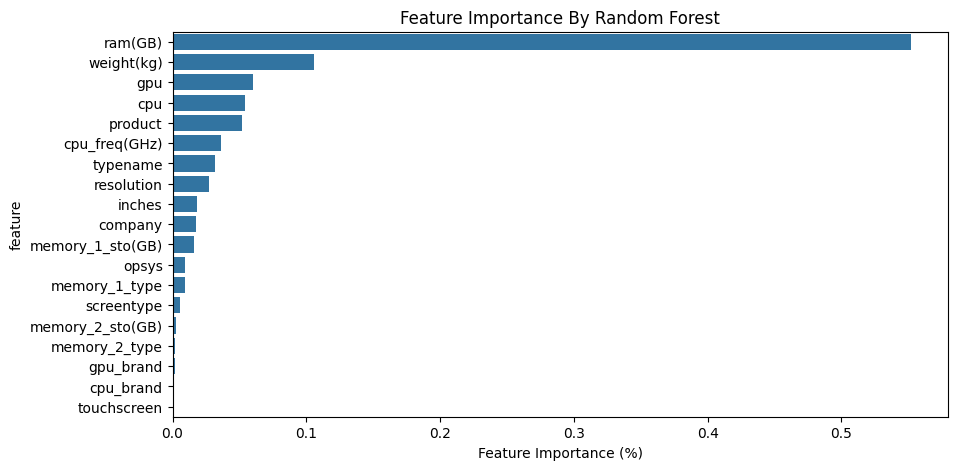

In [564]:
plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='feature', data = randomforest_sorted_features)
plt.title('Feature Importance By Random Forest')
plt.xlabel('Feature Importance (%)')
plt.show()

# MODEL COMPARISON

LinearRegression
Evaluation Metrics:
Mean Squared Error (MSE): 141895.5162
Mean Absolute Error (MAE): 259.9215
R-squared (R2) Score: 0.7070
------------------------------------------------------------------
DecisionTreeRegressor
Evaluation Metrics:
Mean Squared Error (MSE): 124219.1011
Mean Absolute Error (MAE): 219.8147
R-squared (R2) Score: 0.7435
------------------------------------------------------------------
GradientBoostingRegressor
Evaluation Metrics:
Mean Squared Error (MSE): 53371.2757
Mean Absolute Error (MAE): 156.0788
R-squared (R2) Score: 0.8898
------------------------------------------------------------------
XGBRegressor
Evaluation Metrics:
Mean Squared Error (MSE): 56744.6644
Mean Absolute Error (MAE): 153.6000
R-squared (R2) Score: 0.8828
------------------------------------------------------------------


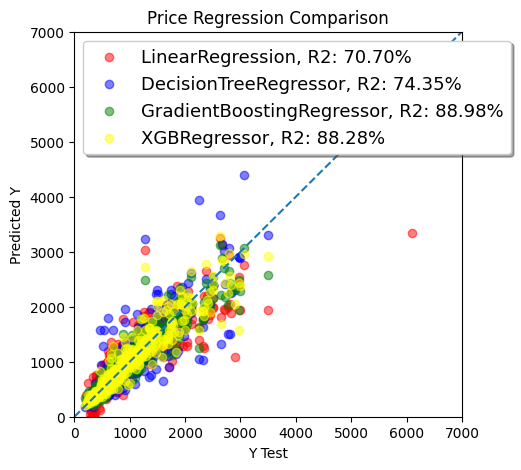

In [565]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return predictions, mse, mae, r2

def print_metrics(model_name, mse, mae, r2):
    print(f"{model_name}")
    print("Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    print('------------------------------------------------------------------')

def plot_comparison(y_test, predictions, color, label):
    plt.scatter(y_test, predictions, alpha=0.5, color=color, label=label)

regression_models = {
    "lr": LinearRegression(),
    "dt": DecisionTreeRegressor(),
    "gb": GradientBoostingRegressor(),
    "xgb": XGBRegressor()
}

models = {}

for model_name, model in regression_models.items():
    models[model_name] = evaluate_model(model, X_train, y_train, X_test, y_test)

plt.figure(figsize=(5, 5))

colors = ["red", "blue", "green", "yellow"]

for i, (model_name, info) in enumerate(models.items()):
    model_fullname = type(regression_models[model_name]).__name__
    print_metrics(model_fullname, info[1], info[2], info[3])
    plot_comparison(y_test, info[0], label=f'{model_fullname}, R2: {info[3]:.2%}', color=colors[i])

plt.plot([0, 7000], [0, 7000], linestyle='--')
plt.axis([0, 7000, 0, 7000])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Price Regression Comparison')
plt.legend(loc='upper left', ncol=1, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In comparison to **Random Forest Regression**, both **Gradient Boosting Regression** and **XGBoost Regression** show improved performance in terms of the evaluation metrics:

Gradient Boosting Regression: The Gradient Boosting Regression model achieves a lower MSE and MAE compared to Random Forest, indicating reduced prediction errors. Additionally, it has a higher R-squared score of 0.9070, suggesting that the model explains more of the target variable's variance.

XGBoost Regression: The XGBoost Regression model further improves upon the results of Gradient Boosting Regression. It achieves a lower MSE and MAE, indicating even fewer prediction errors. Additionally, it has the highest R-squared score of 0.9112, suggesting that it explains the most variance in the target variable among the models compared.

In summary, both Gradient Boosting Regression and XGBoost Regression outperform Random Forest in terms of MSE, MAE, and R-squared score. They provide better predictive performance and capture more of the variance in the target variable, with XGBoost Regression achieving the highest accuracy among the three models.